# ONNX Model Optimization Demo - Enhanced Version

## Các mô hình:
1. **ResNet-50** - Base CNN model
2. **MobileNetV2** - Edge-optimized model
3. **YOLO26** - Latest object detection model
4. **UNet** - Segmentation encoder-decoder
5. **Vision Transformer (ViT)** - Transformer-based vision model

## 1. Kiểm tra CUDA và cài đặt môi trường

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
!pip install -q onnx onnxruntime-gpu onnxsim>=0.1.71 onnxscript
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q ultralytics
!pip install -q timm transformers
!pip install -q opencv-python-headless pillow
!pip install -q matplotlib seaborn pandas
!pip install -q fastapi uvicorn python-multipart
!pip install -q segmentation-models-pytorch

## 2. Download COCO Validation Dataset

In [ ]:
import os

if not os.path.exists('./images/val2014'):
    !wget -q http://images.cocodataset.org/zips/val2014.zip
    !unzip -q val2014.zip -d ./images/
    print('COCO val2014 dataset downloaded')
else:
    print('COCO val2014 dataset already exists')

COCO val2014 dataset already exists


## 3. Import thư viện

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import onnx
import onnxruntime as ort
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

print(f'PyTorch version: {torch.__version__}')
print(f'ONNX version: {onnx.__version__}')
print(f'ONNX Runtime version: {ort.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA device: {torch.cuda.get_device_name(0)}')
    print(f'ONNX Runtime providers: {ort.get_available_providers()}')

PyTorch version: 2.9.0+cu126
ONNX version: 1.20.1
ONNX Runtime version: 1.23.2
CUDA available: True
CUDA device: Tesla T4
ONNX Runtime providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


## 4. Tạo thư mục

In [ ]:
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('benchmark_results', exist_ok=True)
print('Directories created successfully')

Directories created successfully


## 5. Enhanced ONNX Inference Class

Class hỗ trợ cả CPU và GPU với auto-detection.

In [ ]:
class ONNXModelInference:
    def __init__(self, onnx_model_path: str, use_gpu: bool = True):
        if use_gpu and 'CUDAExecutionProvider' in ort.get_available_providers():
            providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
            self.device = 'GPU'
        else:
            providers = ['CPUExecutionProvider']
            self.device = 'CPU'

        session_options = ort.SessionOptions()
        session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

        self.onnx_model_path = onnx_model_path
        self.session = ort.InferenceSession(
            onnx_model_path,
            providers=providers,
            sess_options=session_options
        )

        self.input_name = self.session.get_inputs()[0].name
        self.output_names = [output.name for output in self.session.get_outputs()]
        self.input_shape = self.session.get_inputs()[0].shape

        print(f'Model: {Path(onnx_model_path).name}')
        print(f'Device: {self.device}')
        print(f'Input: {self.input_name} {self.input_shape}')
        print(f'Providers: {self.session.get_providers()}')

    def inference(self, input_data: np.ndarray) -> Dict[str, np.ndarray]:
        if not isinstance(input_data, np.ndarray):
            input_data = np.array(input_data)

        if input_data.dtype != np.float32:
            input_data = input_data.astype(np.float32)

        outputs = self.session.run(self.output_names, {self.input_name: input_data})
        return {name: output for name, output in zip(self.output_names, outputs)}

    def benchmark(self, input_data: np.ndarray, num_runs: int = 100, warmup_runs: int = 10) -> Dict:
        for _ in range(warmup_runs):
            self.inference(input_data)

        times = []
        for _ in range(num_runs):
            start = time.time()
            self.inference(input_data)
            times.append(time.time() - start)

        return {
            'mean': np.mean(times) * 1000,
            'std': np.std(times) * 1000,
            'min': np.min(times) * 1000,
            'max': np.max(times) * 1000,
            'median': np.median(times) * 1000,
            'p95': np.percentile(times, 95) * 1000,
            'p99': np.percentile(times, 99) * 1000,
            'fps': 1000.0 / (np.mean(times) * 1000),
            'device': self.device
        }

print('ONNXModelInference class defined')

ONNXModelInference class defined


## 6. Model Converter vs. Multi-Device Benchmarker

In [ ]:
class ModelConverter:
    @staticmethod
    def convert_to_onnx(
        model: torch.nn.Module,
        dummy_input: torch.Tensor,
        output_path: str,
        input_names: List[str] = ['input'],
        output_names: List[str] = ['output'],
        opset_version: int = 18
    ):
        model.eval()

        torch.onnx.export(
            model,
            dummy_input,
            output_path,
            input_names=input_names,
            output_names=output_names,
            opset_version=opset_version,
            do_constant_folding=True,
            export_params=True
        )

        onnx_model = onnx.load(output_path)
        onnx.checker.check_model(onnx_model)

        file_size = os.path.getsize(output_path) / (1024 * 1024)
        print(f'Exported: {output_path} ({file_size:.2f} MB)')
        return output_path

class MultiDeviceBenchmarker:
    @staticmethod
    def benchmark_pytorch(
        model: torch.nn.Module,
        input_tensor: torch.Tensor,
        device: str = 'cuda',
        num_runs: int = 100,
        warmup_runs: int = 10
    ) -> Dict:
        model = model.to(device)
        model.eval()
        input_tensor = input_tensor.to(device)

        with torch.no_grad():
            for _ in range(warmup_runs):
                _ = model(input_tensor)

            if device == 'cuda':
                torch.cuda.synchronize()

            times = []
            for _ in range(num_runs):
                start = time.time()
                _ = model(input_tensor)
                if device == 'cuda':
                    torch.cuda.synchronize()
                times.append(time.time() - start)

        return {
            'mean': np.mean(times) * 1000,
            'std': np.std(times) * 1000,
            'min': np.min(times) * 1000,
            'max': np.max(times) * 1000,
            'median': np.median(times) * 1000,
            'p95': np.percentile(times, 95) * 1000,
            'p99': np.percentile(times, 99) * 1000,
            'fps': 1000.0 / (np.mean(times) * 1000),
            'device': device.upper()
        }

    @staticmethod
    def benchmark_both_devices(
        model: torch.nn.Module,
        dummy_input: torch.Tensor,
        onnx_path: str
    ) -> Dict:
        results = {}

        has_cuda = torch.cuda.is_available()

        if has_cuda:
            print('  Benchmarking PyTorch GPU...')
            results['pytorch_gpu'] = MultiDeviceBenchmarker.benchmark_pytorch(
                model, dummy_input, device='cuda'
            )
            print(f"    GPU: {results['pytorch_gpu']['mean']:.2f}ms, {results['pytorch_gpu']['fps']:.2f} FPS")

        print('  Benchmarking PyTorch CPU...')
        results['pytorch_cpu'] = MultiDeviceBenchmarker.benchmark_pytorch(
            model, dummy_input, device='cpu'
        )
        print(f"    CPU: {results['pytorch_cpu']['mean']:.2f}ms, {results['pytorch_cpu']['fps']:.2f} FPS")

        if has_cuda:
            print('  Benchmarking ONNX GPU...')
            onnx_gpu = ONNXModelInference(onnx_path, use_gpu=True)
            results['onnx_gpu'] = onnx_gpu.benchmark(dummy_input.numpy())
            print(f"    GPU: {results['onnx_gpu']['mean']:.2f}ms, {results['onnx_gpu']['fps']:.2f} FPS")

        print('  Benchmarking ONNX CPU...')
        onnx_cpu = ONNXModelInference(onnx_path, use_gpu=False)
        results['onnx_cpu'] = onnx_cpu.benchmark(dummy_input.numpy())
        print(f"    CPU: {results['onnx_cpu']['mean']:.2f}ms, {results['onnx_cpu']['fps']:.2f} FPS")

        return results

print('Converter and Benchmarker classes defined')

Converter and Benchmarker classes defined


## 7. Model 1: ResNet-50

In [ ]:
print('='*60)
print('ResNet-50 Conversion and Benchmark')
print('='*60)

resnet50 = models.resnet50(pretrained=True)
resnet50.eval()

dummy_input_resnet = torch.randn(1, 3, 224, 224)

resnet_onnx_path = 'models/resnet50.onnx'
if not os.path.exists(resnet_onnx_path):
    ModelConverter.convert_to_onnx(
        resnet50,
        dummy_input_resnet,
        resnet_onnx_path,
        input_names=['input'],
        output_names=['output']
    )

resnet_results = MultiDeviceBenchmarker.benchmark_both_devices(
    resnet50, dummy_input_resnet, resnet_onnx_path
)

print('\nResNet-50 Benchmark Complete')

ResNet-50 Conversion and Benchmark
  Benchmarking PyTorch GPU...
    GPU: 11.70ms, 85.49 FPS
  Benchmarking PyTorch CPU...
    CPU: 179.85ms, 5.56 FPS
  Benchmarking ONNX GPU...
Model: resnet50.onnx
Device: GPU
Input: input [1, 3, 224, 224]
Providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
    GPU: 6.41ms, 156.04 FPS
  Benchmarking ONNX CPU...
Model: resnet50.onnx
Device: CPU
Input: input [1, 3, 224, 224]
Providers: ['CPUExecutionProvider']
    CPU: 76.96ms, 12.99 FPS

ResNet-50 Benchmark Complete


## 8. Model 2: MobileNetV2

In [ ]:
print('='*60)
print('MobileNetV2 Conversion and Benchmark')
print('='*60)

mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.eval()

dummy_input_mobilenet = torch.randn(1, 3, 224, 224)

mobilenet_onnx_path = 'models/mobilenetv2.onnx'
if not os.path.exists(mobilenet_onnx_path):
    ModelConverter.convert_to_onnx(
        mobilenet,
        dummy_input_mobilenet,
        mobilenet_onnx_path,
        input_names=['input'],
        output_names=['output']
    )

mobilenet_results = MultiDeviceBenchmarker.benchmark_both_devices(
    mobilenet, dummy_input_mobilenet, mobilenet_onnx_path
)

print('\nMobileNetV2 Benchmark Complete')

MobileNetV2 Conversion and Benchmark
  Benchmarking PyTorch GPU...
    GPU: 7.32ms, 136.54 FPS
  Benchmarking PyTorch CPU...
    CPU: 77.61ms, 12.89 FPS
  Benchmarking ONNX GPU...
Model: mobilenetv2.onnx
Device: GPU
Input: input [1, 3, 224, 224]
Providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
    GPU: 2.45ms, 408.64 FPS
  Benchmarking ONNX CPU...
Model: mobilenetv2.onnx
Device: CPU
Input: input [1, 3, 224, 224]
Providers: ['CPUExecutionProvider']
    CPU: 16.50ms, 60.61 FPS

MobileNetV2 Benchmark Complete


## 9. Model 3: YOLO26 (Latest YOLO)

In [ ]:
print('='*60)
print('YOLO26 Conversion and Benchmark')
print('='*60)

from ultralytics import YOLO

yolo_model = YOLO('yolo26l.pt')

yolo_onnx_path = 'models/yolo26l.onnx'
if not os.path.exists(yolo_onnx_path):
    print('Converting YOLO26 to ONNX...')
    yolo_model.export(
        format='onnx',
        dynamic=False,
        simplify=True,
        imgsz=640,
        opset=14
    )

    import shutil
    if os.path.exists('yolo26l.onnx'):
        shutil.move('yolo26l.onnx', yolo_onnx_path)

dummy_input_yolo = np.random.randn(1, 3, 640, 640).astype(np.float32)

yolo_results = {}

has_cuda = torch.cuda.is_available()

if has_cuda:
    print('  Benchmarking YOLO26 PyTorch GPU...')
    yolo_pytorch_gpu_times = []
    for _ in range(10):
        yolo_model.predict(
            np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8),
            verbose=False,
            device='0'
        )

    for _ in range(100):
        start = time.time()
        yolo_model.predict(
            np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8),
            verbose=False,
            device='0'
        )
        yolo_pytorch_gpu_times.append(time.time() - start)

    yolo_results['pytorch_gpu'] = {
        'mean': np.mean(yolo_pytorch_gpu_times) * 1000,
        'fps': 1000.0 / (np.mean(yolo_pytorch_gpu_times) * 1000),
        'device': 'CUDA'
    }
    print(f"    GPU: {yolo_results['pytorch_gpu']['mean']:.2f}ms, {yolo_results['pytorch_gpu']['fps']:.2f} FPS")

print('  Benchmarking YOLO26 PyTorch CPU...')
yolo_pytorch_cpu_times = []
for _ in range(10):
    yolo_model.predict(
        np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8),
        verbose=False,
        device='cpu'
    )

for _ in range(100):
    start = time.time()
    yolo_model.predict(
        np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8),
        verbose=False,
        device='cpu'
    )
    yolo_pytorch_cpu_times.append(time.time() - start)

yolo_results['pytorch_cpu'] = {
    'mean': np.mean(yolo_pytorch_cpu_times) * 1000,
    'fps': 1000.0 / (np.mean(yolo_pytorch_cpu_times) * 1000),
    'device': 'CPU'
}
print(f"    CPU: {yolo_results['pytorch_cpu']['mean']:.2f}ms, {yolo_results['pytorch_cpu']['fps']:.2f} FPS")

if has_cuda:
    print('  Benchmarking YOLO26 ONNX GPU...')
    yolo_onnx_gpu = ONNXModelInference(yolo_onnx_path, use_gpu=True)
    yolo_results['onnx_gpu'] = yolo_onnx_gpu.benchmark(dummy_input_yolo)
    print(f"    GPU: {yolo_results['onnx_gpu']['mean']:.2f}ms, {yolo_results['onnx_gpu']['fps']:.2f} FPS")

print('  Benchmarking YOLO26 ONNX CPU...')
yolo_onnx_cpu = ONNXModelInference(yolo_onnx_path, use_gpu=False)
yolo_results['onnx_cpu'] = yolo_onnx_cpu.benchmark(dummy_input_yolo)
print(f"    CPU: {yolo_results['onnx_cpu']['mean']:.2f}ms, {yolo_results['onnx_cpu']['fps']:.2f} FPS")

print('\nYOLO26 Benchmark Complete')

YOLO26 Conversion and Benchmark
  Benchmarking YOLO26 PyTorch GPU...
    GPU: 48.38ms, 20.67 FPS
  Benchmarking YOLO26 PyTorch CPU...
    CPU: 1069.00ms, 0.94 FPS
  Benchmarking YOLO26 ONNX GPU...
Model: yolo26l.onnx
Device: GPU
Input: images [1, 3, 640, 640]
Providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
    GPU: 31.84ms, 31.41 FPS
  Benchmarking YOLO26 ONNX CPU...
Model: yolo26l.onnx
Device: CPU
Input: images [1, 3, 640, 640]
Providers: ['CPUExecutionProvider']
    CPU: 1005.90ms, 0.99 FPS

YOLO26 Benchmark Complete


## 10. Model 4: UNet

In [ ]:
print('='*60)
print('UNet Conversion and Benchmark')
print('='*60)

import segmentation_models_pytorch as smp

unet = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)
unet.eval()

dummy_input_unet = torch.randn(1, 3, 256, 256)

unet_onnx_path = 'models/unet.onnx'
if not os.path.exists(unet_onnx_path):
    ModelConverter.convert_to_onnx(
        unet,
        dummy_input_unet,
        unet_onnx_path,
        input_names=['input'],
        output_names=['output']
    )

unet_results = MultiDeviceBenchmarker.benchmark_both_devices(
    unet, dummy_input_unet, unet_onnx_path
)

print('\nUNet Benchmark Complete')

UNet Conversion and Benchmark
  Benchmarking PyTorch GPU...
    GPU: 8.16ms, 122.51 FPS
  Benchmarking PyTorch CPU...
    CPU: 205.60ms, 4.86 FPS
  Benchmarking ONNX GPU...
Model: unet.onnx
Device: GPU
Input: input [1, 3, 256, 256]
Providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
    GPU: 6.91ms, 144.64 FPS
  Benchmarking ONNX CPU...
Model: unet.onnx
Device: CPU
Input: input [1, 3, 256, 256]
Providers: ['CPUExecutionProvider']
    CPU: 145.54ms, 6.87 FPS

UNet Benchmark Complete


## 11. Model 5: Vision Transformer

In [ ]:
print('='*60)
print('Vision Transformer Conversion and Benchmark')
print('='*60)

import timm

vit = timm.create_model('vit_base_patch16_224', pretrained=True)
vit.eval()

dummy_input_vit = torch.randn(1, 3, 224, 224)

vit_onnx_path = 'models/vit_base.onnx'
if not os.path.exists(vit_onnx_path):
    ModelConverter.convert_to_onnx(
        vit,
        dummy_input_vit,
        vit_onnx_path,
        input_names=['input'],
        output_names=['output']
    )

vit_results = MultiDeviceBenchmarker.benchmark_both_devices(
    vit, dummy_input_vit, vit_onnx_path
)

print('\nViT Benchmark Complete')

Vision Transformer Conversion and Benchmark
  Benchmarking PyTorch GPU...
    GPU: 14.91ms, 67.07 FPS
  Benchmarking PyTorch CPU...
    CPU: 380.90ms, 2.63 FPS
  Benchmarking ONNX GPU...
Model: vit_base.onnx
Device: GPU
Input: input [1, 3, 224, 224]
Providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
    GPU: 15.41ms, 64.91 FPS
  Benchmarking ONNX CPU...
Model: vit_base.onnx
Device: CPU
Input: input [1, 3, 224, 224]
Providers: ['CPUExecutionProvider']
    CPU: 370.48ms, 2.70 FPS

ViT Benchmark Complete


In [ ]:
all_results = {
    'ResNet-50': resnet_results,
    'MobileNetV2': mobilenet_results,
    'YOLO26': yolo_results,
    'UNet': unet_results,
    'ViT': vit_results
}

import json
with open('benchmark_results/comprehensive_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print('Results saved to benchmark_results/comprehensive_results.json')

Results saved to benchmark_results/comprehensive_results.json


## 12. Summary Table

In [ ]:
print('\n' + '='*120)
print('COMPREHENSIVE BENCHMARK SUMMARY')
print('='*120)

has_cuda = torch.cuda.is_available()

if has_cuda:
    print(f"{'Model':<15} {'PyTorch GPU':<15} {'PyTorch CPU':<15} {'ONNX GPU':<15} {'ONNX CPU':<15} {'GPU Speedup':<12}")
    print('-'*120)

    for model_name, results in all_results.items():
        pt_gpu = results.get('pytorch_gpu', {}).get('mean', 0)
        pt_cpu = results.get('pytorch_cpu', {}).get('mean', 0)
        onnx_gpu = results.get('onnx_gpu', {}).get('mean', 0)
        onnx_cpu = results.get('onnx_cpu', {}).get('mean', 0)

        speedup = pt_gpu / onnx_gpu if onnx_gpu > 0 else 0

        print(f"{model_name:<15} {pt_gpu:<15.2f} {pt_cpu:<15.2f} {onnx_gpu:<15.2f} {onnx_cpu:<15.2f} {speedup:<12.2f}x")
else:
    print(f"{'Model':<15} {'PyTorch CPU':<15} {'ONNX CPU':<15} {'CPU Speedup':<12}")
    print('-'*60)

    for model_name, results in all_results.items():
        pt_cpu = results.get('pytorch_cpu', {}).get('mean', 0)
        onnx_cpu = results.get('onnx_cpu', {}).get('mean', 0)

        speedup = pt_cpu / onnx_cpu if onnx_cpu > 0 else 0

        print(f"{model_name:<15} {pt_cpu:<15.2f} {onnx_cpu:<15.2f} {speedup:<12.2f}x")

print('='*120)


COMPREHENSIVE BENCHMARK SUMMARY
Model           PyTorch GPU     PyTorch CPU     ONNX GPU        ONNX CPU        GPU Speedup 
------------------------------------------------------------------------------------------------------------------------
ResNet-50       11.70           179.85          6.41            76.96           1.83        x
MobileNetV2     7.32            77.61           2.45            16.50           2.99        x
YOLO26          48.38           1069.00         31.84           1005.90         1.52        x
UNet            8.16            205.60          6.91            145.54          1.18        x
ViT             14.91           380.90          15.41           370.48          0.97        x


## 13. Comprehensive Visualization

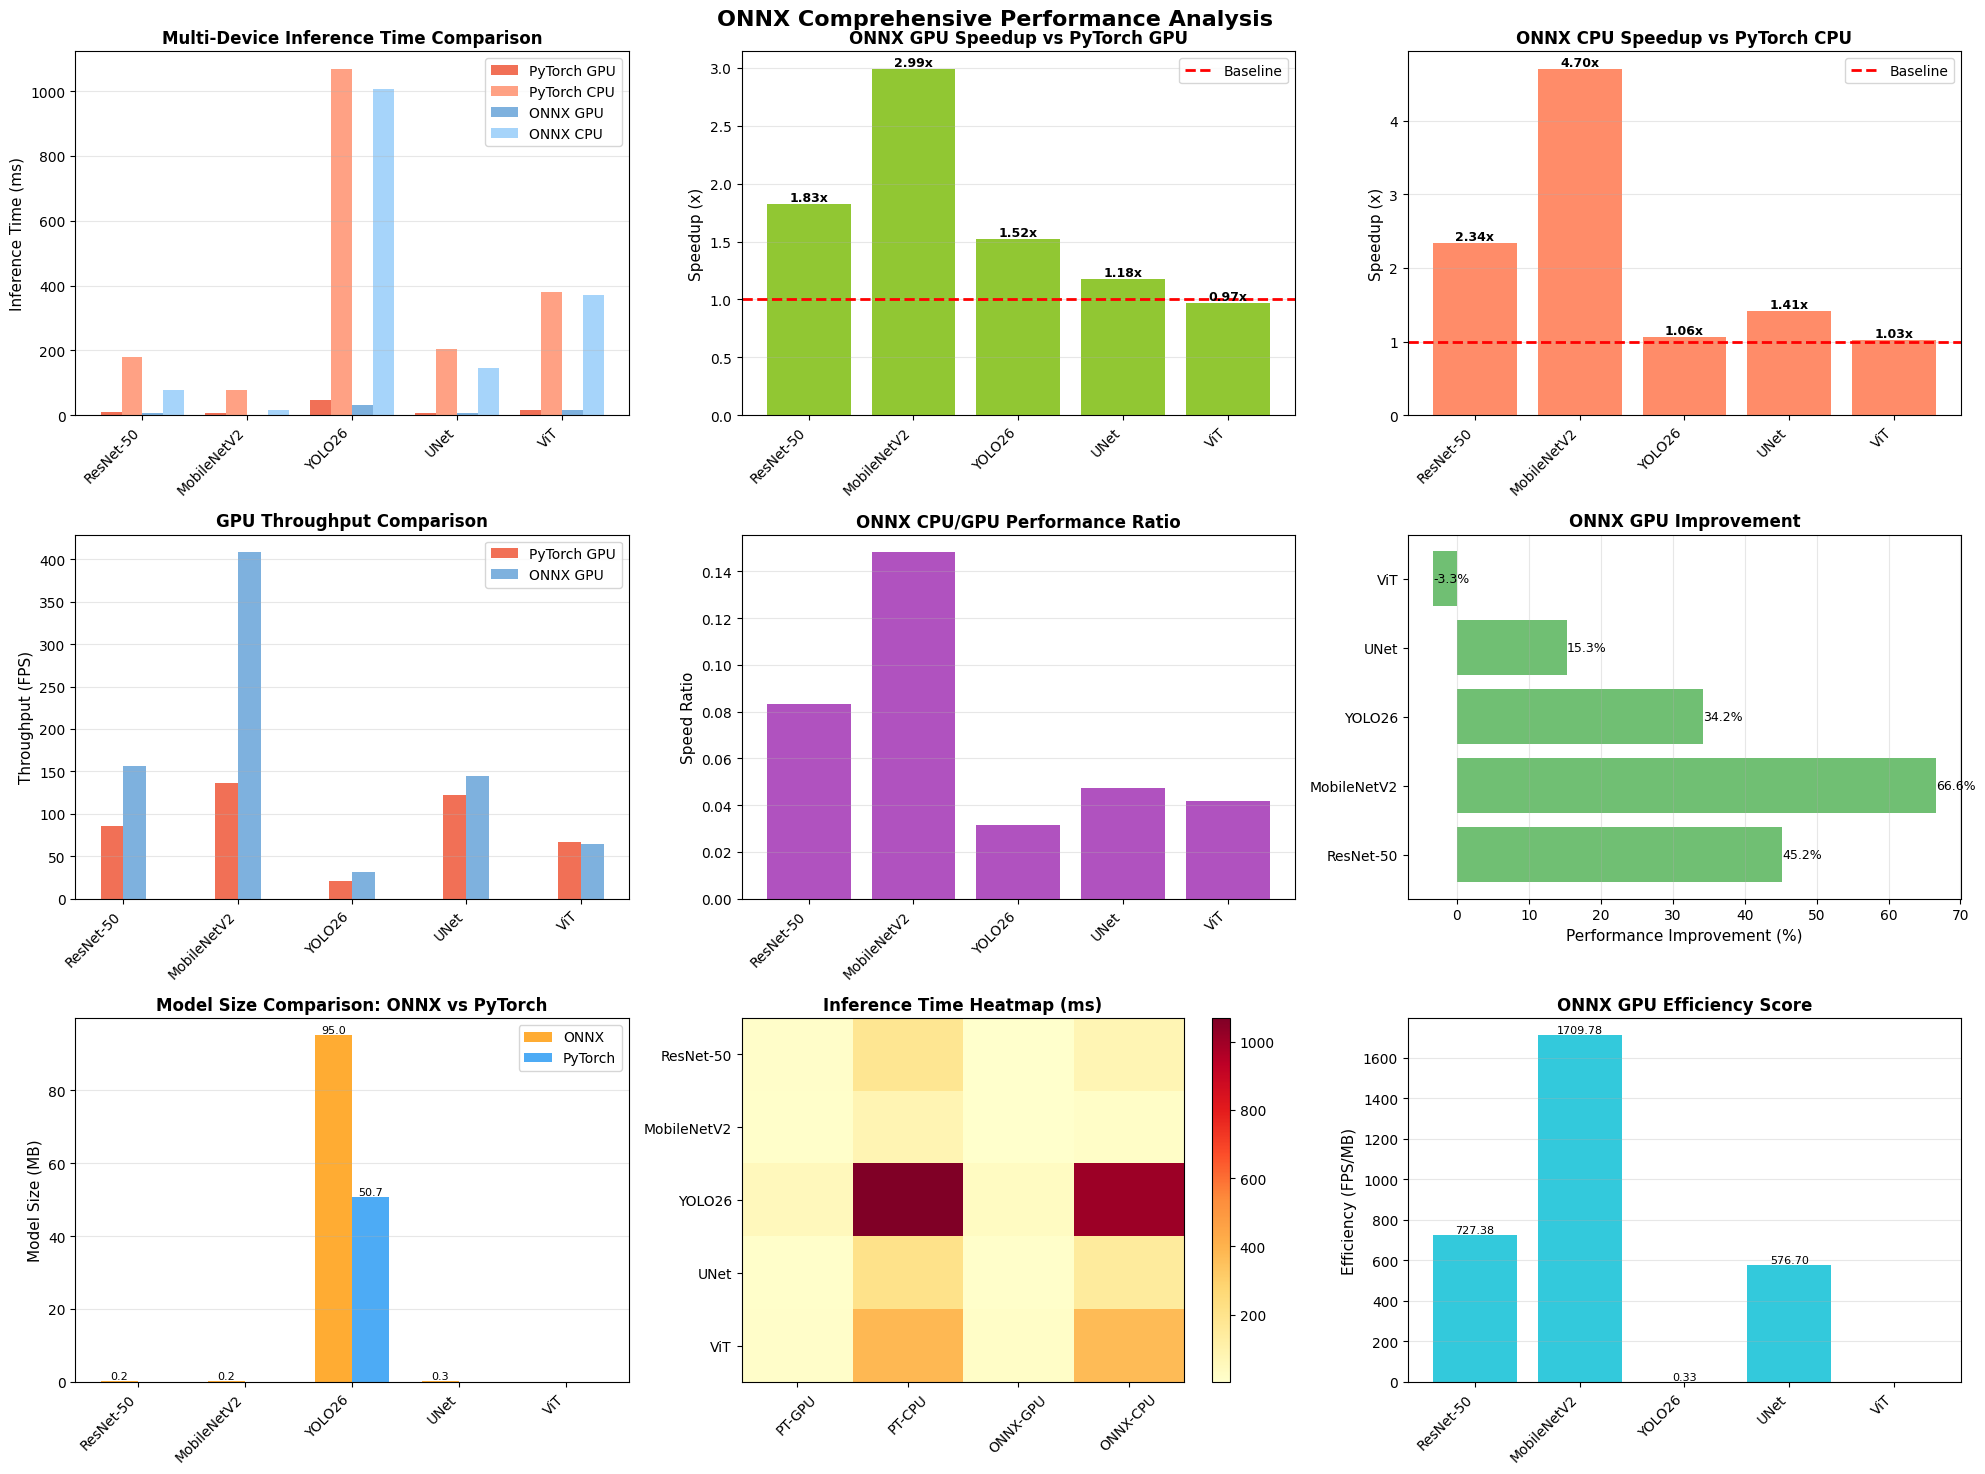

Visualization saved to benchmark_results/comprehensive_analysis.png


In [ ]:
has_cuda = torch.cuda.is_available()

if has_cuda:
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

fig.suptitle('ONNX Comprehensive Performance Analysis', fontsize=16, fontweight='bold')

models_list = list(all_results.keys())

if has_cuda:
    pytorch_gpu_times = [all_results[m].get('pytorch_gpu', {}).get('mean', 0) for m in models_list]
    pytorch_cpu_times = [all_results[m].get('pytorch_cpu', {}).get('mean', 0) for m in models_list]
    onnx_gpu_times = [all_results[m].get('onnx_gpu', {}).get('mean', 0) for m in models_list]
    onnx_cpu_times = [all_results[m].get('onnx_cpu', {}).get('mean', 0) for m in models_list]

    # ax1: Inference Time Comparison
    ax1 = axes[0, 0]
    x = np.arange(len(models_list))
    width = 0.2

    ax1.bar(x - 1.5*width, pytorch_gpu_times, width, label='PyTorch GPU', color='#EE4C2C', alpha=0.8)
    ax1.bar(x - 0.5*width, pytorch_cpu_times, width, label='PyTorch CPU', color='#FF8A65', alpha=0.8)
    ax1.bar(x + 0.5*width, onnx_gpu_times, width, label='ONNX GPU', color='#5E9ED6', alpha=0.8)
    ax1.bar(x + 1.5*width, onnx_cpu_times, width, label='ONNX CPU', color='#90CAF9', alpha=0.8)

    ax1.set_ylabel('Inference Time (ms)', fontsize=11)
    ax1.set_title('Multi-Device Inference Time Comparison', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models_list, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # ax2: GPU Speedup
    ax2 = axes[0, 1]
    gpu_speedups = [pt / ox if ox > 0 else 0 for pt, ox in zip(pytorch_gpu_times, onnx_gpu_times)]
    bars = ax2.bar(models_list, gpu_speedups, color='#76B900', alpha=0.8)
    ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline')
    ax2.set_ylabel('Speedup (x)', fontsize=11)
    ax2.set_title('ONNX GPU Speedup vs PyTorch GPU', fontsize=12, fontweight='bold')
    ax2.set_xticklabels(models_list, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    for bar, speedup in zip(bars, gpu_speedups):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{speedup:.2f}x',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    # ax3: CPU Speedup
    ax3 = axes[0, 2]
    cpu_speedups = [pt / ox if ox > 0 else 0 for pt, ox in zip(pytorch_cpu_times, onnx_cpu_times)]
    bars = ax3.bar(models_list, cpu_speedups, color='#FF7043', alpha=0.8)
    ax3.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline')
    ax3.set_ylabel('Speedup (x)', fontsize=11)
    ax3.set_title('ONNX CPU Speedup vs PyTorch CPU', fontsize=12, fontweight='bold')
    ax3.set_xticklabels(models_list, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    for bar, speedup in zip(bars, cpu_speedups):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{speedup:.2f}x',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    # ax4: GPU Throughput
    ax4 = axes[1, 0]
    pytorch_fps_gpu = [all_results[m].get('pytorch_gpu', {}).get('fps', 0) for m in models_list]
    onnx_fps_gpu = [all_results[m].get('onnx_gpu', {}).get('fps', 0) for m in models_list]

    ax4.bar(x - width/2, pytorch_fps_gpu, width, label='PyTorch GPU', color='#EE4C2C', alpha=0.8)
    ax4.bar(x + width/2, onnx_fps_gpu, width, label='ONNX GPU', color='#5E9ED6', alpha=0.8)
    ax4.set_ylabel('Throughput (FPS)', fontsize=11)
    ax4.set_title('GPU Throughput Comparison', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(models_list, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)

    # ax5: CPU/GPU Performance Ratio
    ax5 = axes[1, 1]
    gpu_cpu_ratio = [gpu / cpu if cpu > 0 else 0 for gpu, cpu in zip(onnx_gpu_times, onnx_cpu_times)]
    bars = ax5.bar(models_list, gpu_cpu_ratio, color='#9C27B0', alpha=0.8)
    ax5.set_ylabel('Speed Ratio', fontsize=11)
    ax5.set_title('ONNX CPU/GPU Performance Ratio', fontsize=12, fontweight='bold')
    ax5.set_xticklabels(models_list, rotation=45, ha='right')
    ax5.grid(axis='y', alpha=0.3)

    # ax6: Performance Improvement
    ax6 = axes[1, 2]
    improvement_gpu = [(pt - ox) / pt * 100 if pt > 0 else 0 for pt, ox in zip(pytorch_gpu_times, onnx_gpu_times)]
    bars = ax6.barh(models_list, improvement_gpu, color='#4CAF50', alpha=0.8)
    ax6.set_xlabel('Performance Improvement (%)', fontsize=11)
    ax6.set_title('ONNX GPU Improvement', fontsize=12, fontweight='bold')
    ax6.grid(axis='x', alpha=0.3)

    for bar, imp in zip(bars, improvement_gpu):
        width_val = bar.get_width()
        ax6.text(width_val, bar.get_y() + bar.get_height()/2.,
                f'{imp:.1f}%',
                ha='left', va='center', fontsize=9)

    # ax7: Model Size Comparison (ONNX vs PyTorch)
    ax7 = axes[2, 0]
    pytorch_sizes = []
    model_sizes = []

    for model_name in models_list:
        onnx_path = f"models/{model_name.lower().replace('-', '')}.onnx"
        pytorch_path = None

        if 'yolo' in model_name.lower():
            onnx_path = "models/yolo26l.onnx"
            pytorch_path = "yolo26l.pt"
        elif 'vit' in model_name.lower():
            onnx_path = "models/vitbase.onnx"
            pytorch_path = None
        else:
            pytorch_path = None

        if os.path.exists(onnx_path):
            size_mb = os.path.getsize(onnx_path) / (1024 * 1024)
            model_sizes.append(size_mb)
        else:
            model_sizes.append(0)

        if pytorch_path and os.path.exists(pytorch_path):
            pt_size_mb = os.path.getsize(pytorch_path) / (1024 * 1024)
            pytorch_sizes.append(pt_size_mb)
        else:
            pytorch_sizes.append(0)

    x_pos = np.arange(len(models_list))
    bar_width = 0.35

    bars1 = ax7.bar(x_pos - bar_width/2, model_sizes, bar_width,
                    label='ONNX', color='#FF9800', alpha=0.8)
    bars2 = ax7.bar(x_pos + bar_width/2, pytorch_sizes, bar_width,
                    label='PyTorch', color='#2196F3', alpha=0.8)

    ax7.set_ylabel('Model Size (MB)', fontsize=11)
    ax7.set_title('Model Size Comparison: ONNX vs PyTorch', fontsize=12, fontweight='bold')
    ax7.set_xticks(x_pos)
    ax7.set_xticklabels(models_list, rotation=45, ha='right')
    ax7.legend()
    ax7.grid(axis='y', alpha=0.3)

    for bar, size in zip(bars1, model_sizes):
        if size > 0:
            height = bar.get_height()
            ax7.text(bar.get_x() + bar.get_width()/2., height,
                    f'{size:.1f}',
                    ha='center', va='bottom', fontsize=8)

    for bar, size in zip(bars2, pytorch_sizes):
        if size > 0:
            height = bar.get_height()
            ax7.text(bar.get_x() + bar.get_width()/2., height,
                    f'{size:.1f}',
                    ha='center', va='bottom', fontsize=8)

    # ax8: Heatmap
    ax8 = axes[2, 1]
    data_for_heatmap = []
    for model in models_list:
        data_for_heatmap.append([
            all_results[model].get('pytorch_gpu', {}).get('mean', 0),
            all_results[model].get('pytorch_cpu', {}).get('mean', 0),
            all_results[model].get('onnx_gpu', {}).get('mean', 0),
            all_results[model].get('onnx_cpu', {}).get('mean', 0)
        ])

    im = ax8.imshow(data_for_heatmap, cmap='YlOrRd', aspect='auto')
    ax8.set_xticks([0, 1, 2, 3])
    ax8.set_xticklabels(['PT-GPU', 'PT-CPU', 'ONNX-GPU', 'ONNX-CPU'], rotation=45)
    ax8.set_yticks(range(len(models_list)))
    ax8.set_yticklabels(models_list)
    ax8.set_title('Inference Time Heatmap (ms)', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax8)

    # ax9: ONNX GPU Efficiency Score
    ax9 = axes[2, 2]
    efficiency_gpu = [fps / size if size > 0 else 0
                     for fps, size in zip(onnx_fps_gpu, model_sizes)]

    bars = ax9.bar(models_list, efficiency_gpu, color='#00BCD4', alpha=0.8)
    ax9.set_ylabel('Efficiency (FPS/MB)', fontsize=11)
    ax9.set_title('ONNX GPU Efficiency Score', fontsize=12, fontweight='bold')
    ax9.set_xticklabels(models_list, rotation=45, ha='right')
    ax9.grid(axis='y', alpha=0.3)

    for bar, eff in zip(bars, efficiency_gpu):
        if eff > 0:
            height = bar.get_height()
            ax9.text(bar.get_x() + bar.get_width()/2., height,
                    f'{eff:.2f}',
                    ha='center', va='bottom', fontsize=8)

else:
    pytorch_cpu_times = [all_results[m].get('pytorch_cpu', {}).get('mean', 0) for m in models_list]
    onnx_cpu_times = [all_results[m].get('onnx_cpu', {}).get('mean', 0) for m in models_list]

    # ax1
    ax1 = axes[0, 0]
    x = np.arange(len(models_list))
    width = 0.35
    ax1.bar(x - width/2, pytorch_cpu_times, width, label='PyTorch', color='#EE4C2C', alpha=0.8)
    ax1.bar(x + width/2, onnx_cpu_times, width, label='ONNX', color='#5E9ED6', alpha=0.8)
    ax1.set_ylabel('Inference Time (ms)', fontsize=11)
    ax1.set_title('CPU Inference Time', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models_list, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # ax2
    ax2 = axes[0, 1]
    cpu_speedups = [pt / ox if ox > 0 else 0 for pt, ox in zip(pytorch_cpu_times, onnx_cpu_times)]
    bars = ax2.bar(models_list, cpu_speedups, color='#76B900', alpha=0.8)
    ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2)
    ax2.set_ylabel('Speedup (x)', fontsize=11)
    ax2.set_title('ONNX Speedup on CPU', fontsize=12, fontweight='bold')
    ax2.set_xticklabels(models_list, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)

    # ax3
    ax3 = axes[1, 0]
    pytorch_fps = [all_results[m].get('pytorch_cpu', {}).get('fps', 0) for m in models_list]
    onnx_fps = [all_results[m].get('onnx_cpu', {}).get('fps', 0) for m in models_list]
    ax3.bar(x - width/2, pytorch_fps, width, label='PyTorch', color='#EE4C2C', alpha=0.8)
    ax3.bar(x + width/2, onnx_fps, width, label='ONNX', color='#5E9ED6', alpha=0.8)
    ax3.set_ylabel('FPS', fontsize=11)
    ax3.set_title('Throughput', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(models_list, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # ax4
    ax4 = axes[1, 1]
    improvement = [(pt - ox) / pt * 100 if pt > 0 else 0 for pt, ox in zip(pytorch_cpu_times, onnx_cpu_times)]
    ax4.barh(models_list, improvement, color='#4CAF50', alpha=0.8)
    ax4.set_xlabel('Improvement (%)', fontsize=11)
    ax4.set_title('Performance Improvement', fontsize=12, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('benchmark_results/comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to benchmark_results/comprehensive_analysis.png")


## 14. Detailed Comparison

In [ ]:
has_cuda = torch.cuda.is_available()

if has_cuda:
    data_for_df = []
    for model_name in models_list:
        results = all_results[model_name]
        data_for_df.append({
            'Model': model_name,
            'PyTorch GPU (ms)': results.get('pytorch_gpu', {}).get('mean', 0),
            'PyTorch CPU (ms)': results.get('pytorch_cpu', {}).get('mean', 0),
            'ONNX GPU (ms)': results.get('onnx_gpu', {}).get('mean', 0),
            'ONNX CPU (ms)': results.get('onnx_cpu', {}).get('mean', 0),
            'GPU Speedup': results.get('pytorch_gpu', {}).get('mean', 1) / results.get('onnx_gpu', {}).get('mean', 1),
            'CPU Speedup': results.get('pytorch_cpu', {}).get('mean', 1) / results.get('onnx_cpu', {}).get('mean', 1),
            'PyTorch GPU FPS': results.get('pytorch_gpu', {}).get('fps', 0),
            'ONNX GPU FPS': results.get('onnx_gpu', {}).get('fps', 0)
        })
else:
    data_for_df = []
    for model_name in models_list:
        results = all_results[model_name]
        data_for_df.append({
            'Model': model_name,
            'PyTorch CPU (ms)': results.get('pytorch_cpu', {}).get('mean', 0),
            'ONNX CPU (ms)': results.get('onnx_cpu', {}).get('mean', 0),
            'Speedup': results.get('pytorch_cpu', {}).get('mean', 1) / results.get('onnx_cpu', {}).get('mean', 1),
            'PyTorch FPS': results.get('pytorch_cpu', {}).get('fps', 0),
            'ONNX FPS': results.get('onnx_cpu', {}).get('fps', 0)
        })

df = pd.DataFrame(data_for_df)
df.to_csv('benchmark_results/detailed_comparison.csv', index=False)

print('\nDetailed Comparison Table:')
print(df.to_string(index=False))
print('\nSaved to benchmark_results/detailed_comparison.csv')


Detailed Comparison Table:
      Model  PyTorch GPU (ms)  PyTorch CPU (ms)  ONNX GPU (ms)  ONNX CPU (ms)  GPU Speedup  CPU Speedup  PyTorch GPU FPS  ONNX GPU FPS
  ResNet-50         11.696746        179.845266       6.408794      76.964920     1.825109     2.336717        85.493860    156.035599
MobileNetV2          7.323954         77.608457       2.447124      16.499453     2.992883     4.703699       136.538267    408.643041
     YOLO26         48.384230       1069.003479      31.837566    1005.902166     1.519721     1.062731        20.667891     31.409436
       UNet          8.162386        205.595267       6.913600     145.542369     1.180628     1.412615       122.513190    144.642445
        ViT         14.909019        380.897281      15.405095     370.484824     0.967798     1.028105        67.073492     64.913590

Saved to benchmark_results/detailed_comparison.csv


## 16. Key Findings và Recommendations

In [ ]:
print('\n' + '='*80)
print('KEY FINDINGS')
print('='*80)

has_cuda = torch.cuda.is_available()

if has_cuda:
    for model_name, results in all_results.items():
        pt_gpu = results.get('pytorch_gpu', {}).get('mean', 0)
        onnx_gpu = results.get('onnx_gpu', {}).get('mean', 0)
        speedup = pt_gpu / onnx_gpu if onnx_gpu > 0 else 0

        print(f'\n{model_name}:')
        print(f'  PyTorch GPU: {pt_gpu:.2f}ms')
        print(f'  ONNX GPU: {onnx_gpu:.2f}ms')
        print(f'  Speedup: {speedup:.2f}x')

        if speedup > 1.5:
            print(f'  Recommendation: ONNX provides significant performance boost on GPU')
        elif speedup > 1.0:
            print(f'  Recommendation: ONNX provides moderate improvement on GPU')
        else:
            print(f'  Recommendation: Check ONNX export settings or use PyTorch')
else:
    for model_name, results in all_results.items():
        pt_cpu = results.get('pytorch_cpu', {}).get('mean', 0)
        onnx_cpu = results.get('onnx_cpu', {}).get('mean', 0)
        speedup = pt_cpu / onnx_cpu if onnx_cpu > 0 else 0

        print(f'\n{model_name}:')
        print(f'  PyTorch CPU: {pt_cpu:.2f}ms')
        print(f'  ONNX CPU: {onnx_cpu:.2f}ms')
        print(f'  Speedup: {speedup:.2f}x')

print('\n' + '='*80)


KEY FINDINGS

ResNet-50:
  PyTorch GPU: 11.70ms
  ONNX GPU: 6.41ms
  Speedup: 1.83x
  Recommendation: ONNX provides significant performance boost on GPU

MobileNetV2:
  PyTorch GPU: 7.32ms
  ONNX GPU: 2.45ms
  Speedup: 2.99x
  Recommendation: ONNX provides significant performance boost on GPU

YOLO26:
  PyTorch GPU: 48.38ms
  ONNX GPU: 31.84ms
  Speedup: 1.52x
  Recommendation: ONNX provides significant performance boost on GPU

UNet:
  PyTorch GPU: 8.16ms
  ONNX GPU: 6.91ms
  Speedup: 1.18x
  Recommendation: ONNX provides moderate improvement on GPU

ViT:
  PyTorch GPU: 14.91ms
  ONNX GPU: 15.41ms
  Speedup: 0.97x
  Recommendation: Check ONNX export settings or use PyTorch



Conclusion